## Step2.MVN and HEQ
- MVN: mean and variance normalization
- HEQ: histogram equalization

In [1]:
import numpy as np
import scipy

import maad
import librosa
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

from config import *
from utils import *

<Figure size 432x360 with 0 Axes>

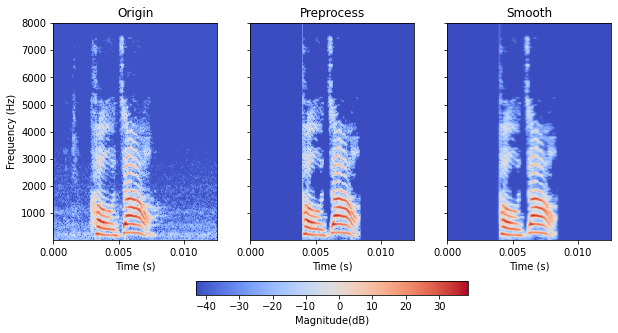

In [2]:
s, fs = librosa.load(r'D:\srdp\dataset\data\kouzhao\kouzhao.025.wav',sr=16000) 
s1 = process1(s)
Axx_dB = draw_spec(s1,show=False,retn=True)
Axx_dB_std1 = maad.sound.smooth(Axx_dB, std=1.0)
draw_spec(s,s1,Axx_dB_std1,name=['Origin','Preprocess','Smooth'],a=10,bar=True)

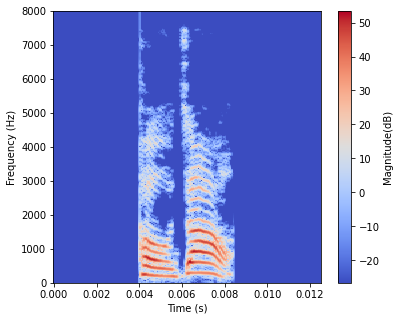

In [3]:
s2 = mvn(s1)
Axx_dB_std1_mvn = draw_spec(s2,retn=True)

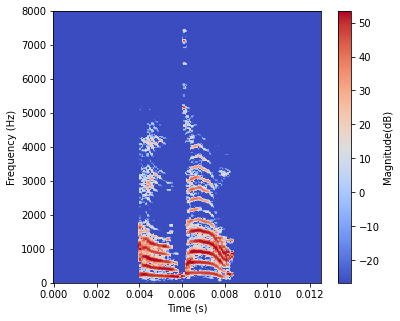

In [4]:
from skimage import exposure
from skimage.util import img_as_ubyte
img = img_as_ubyte(Axx_dB_std1_mvn/np.max(Axx_dB_std1_mvn))
img_eq = exposure.equalize_hist(img)
min_max_scaler2 = preprocessing.MinMaxScaler(feature_range=(np.min(Axx_dB_std1_mvn),np.max(Axx_dB_std1_mvn)))
I_minmax = min_max_scaler2.fit_transform(img_eq)
draw_spec(I_minmax)

In [5]:
A_signal = librosa.stft(s, n_fft=FS, hop_length=HOP, win_length=WIN) 
process2 = librosa.istft(librosa.db_to_amplitude(I_minmax) * np.exp(1j * np.angle(A_signal)), hop_length=HOP, win_length=WIN)
Audio(process2, rate=FS)

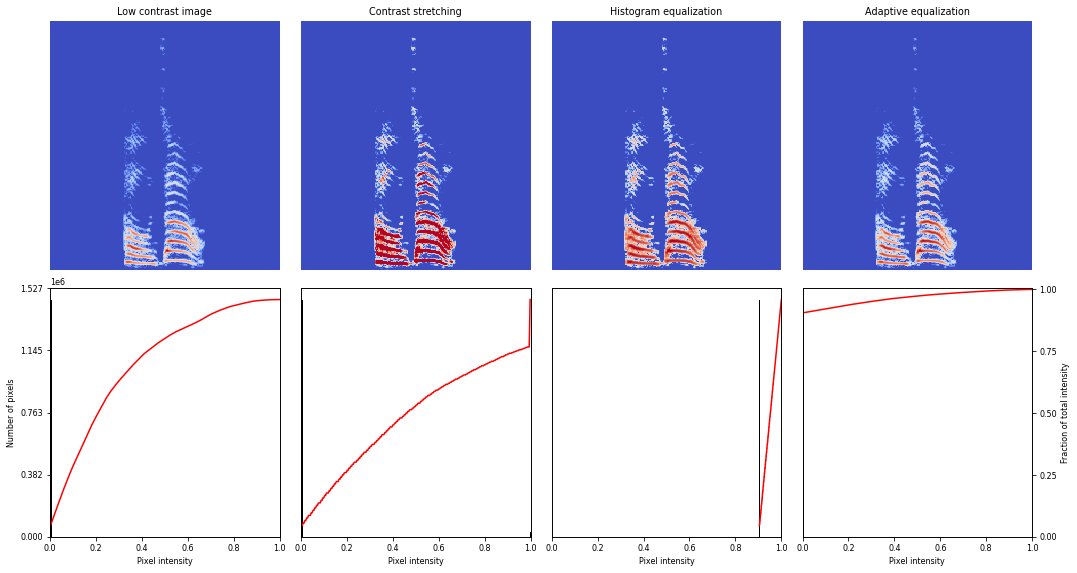

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure
from skimage.util import img_as_ubyte

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    #ax_img.imshow(image, cmap=plt.cm.gray)
    Y = np.arange(0,np.shape(image)[0],1)
    X = np.arange(0,np.shape(image)[1]/FS,1/FS)
    ax_img.pcolormesh(X, Y, image, shading='auto', cmap="coolwarm")
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = img_as_ubyte(Axx_dB_std1_mvn/np.max(Axx_dB_std1_mvn))

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(15, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()